# Hudson and Thames Apprentichsip Application: Pairs Selection with OPTICS

## Purpose
The purpose of this notebook is to fulfill the requirement for the Hudson and Thames apprenticeship application:
https://github.com/hudson-and-thames/oct_applications

## Methodology
This notebook follows the implementation of Section III: Proposed Pairs Selection Framework  from [Enhancing a Pairs Trading strategy with the application of Machine Learning](http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf). (Hereafter refered to as the Sarmento paper). I attemtp to follow the author and analyze Commoditiy ETFs, albeit with daily data (instead of 5 min data as used by the author).

I implemention sections A, B and C from the Sarmento paper. 

Section A implements dimension reduction via Principal Component Analysis (PCA). Section B implements clustering (after dimension reduction) using Ordering Points To Identify the Clustering Structure (OPICS).

Section C entails 4 rules for pairs selection:
 - cointegration*
 - mean crossing (at least 12 times per year on average)
 - mean reversion (Hurst exponent <0.5)
 - 1 day < half-life < 1 year (1year = 250 trading days)

*conitegration is assumed to be the minimum criteria.  I refer to the other criteria as 'additional criteria'.

In addition to sections A, B and C I analyse the impact of the additional criteria (both individually and in combination). To do so, I generate clusters, identify cointegrating pairs within each cluster and estimate cointegration coefficients on data from 2015-2018 (formation period). I then analyze impact on 2019 and 2020 data (validation period). To analyze the impact I implement a simple 30 day 2SD Bollinger band trading rule over each of the pairs for the validation period using cointegration coefficient derived in the formation period.

Note: backtests make do no include slippage or comissions but are intended as a comparison accross selction criteria. Backtests do not compound returns.


## WIP - improvements

Notable TODOs:
- include slippage and comissions in backtets.
- source more ETF data.
- incorporate dynamic (ie, Kalman filter-based) cointegration coefficient into backtests.
- one of the unit tests fails. Derived half-life is approximately as expecteed, but with a negative sign. This should be investigated.


## Results
PCA and OPTICS combine to generate clusters as expected. Moreover, a 2SD Bollinger band trading system based on these cointegrated pairs within these clusters generates relatively profitable and low risk strategies, when tested on out-of-sample data (2019-2020). (Cavet: ingoring slippage and comissions). This is comforting given the volatity seen in markets earlier this year.

The additional trading criteria rules have little impace on overall out-of-sample backtest resuts. The only rule that makes a difference is the half-life rule AND it is only the lower-bound (half-life > 1 day) of the rule that constrains the results. (When I remove the lower bound the results were the same accross all criteria).

## Next Steps
Out-of-sample backtest results appear to be sensitive to minimum cluster size: A lower minimum cluster size leads to more but smaller clusters, and thus fewer paris within each cluster. While 2 would be the minimum cluster size for pairs trading, there seems to be benefits in terms of risk and return to have a higher minimum and thus fewer clusters. This should be optimized in-sample and validated out-of-sample.

The dataset is heavily reliant on metals ETFs.  The dataset should be expanded to see if the results are robust.


## Library import
The following python libraries are used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

import yfinance as yf

from sklearn.cluster import  OPTICS
from sklearn.decomposition import PCA
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint


## Data import
Daily closing price data is saved as pickle

In [2]:
tickers = ['DBA', 'JO', 'CORN', 'WEAT', 'SGG', 'SOYB', 'NIB', 'JJG', 'CANE', 'COW', 'BAL', 'JJA', 'JJS', 'FUD', 'UAG', 'TAGS', 'FUE', 'GRU', 'RJA', 'JJU', 'GLD', 'IAU', 'SLV', 'PDBC', 'DBC', 'USO', 'GSG', 'SGOL', 'DJP', 'GLDM', 'PPLT', 'UGAZ', 'BAR', 'USCI', 'UWT', 'UCO', 'GLTR', 'SIVR', 'DBO', 'UNG', 'DGAZ', 'PALL', 'USLV', 'AGQ', 'FTGC', 'DBB', 'BCI', 'DWT', 'OUNZ', 'OILU', 'GCC', 'UGLD', 'DBP', 'AAAU', 'OIL', 'BNO', 'DGL', 'SCO', 'DBE', 'DGP', 'UGL', 'UCI', 'USL', 'COMB', 'BCM', 'OILK', 'UGA', 'COM', 'CMDY', 'GSP', 'GLDI', 'DJCI', 'DSLV', 'GLDW', 'BOIL', 'USOU', 'ZSL', 'GLL', 'SLVO', 'OILD', 'WTIU', 'DGLD', 'DZZ', 'OILX', 'JJC', 'CPER', 'DBS', 'DTO', 'KOLD', 'DGZ', 'USOI', 'JJN', 'COMG', 'UBG', 'UCIB', 'IAUF', 'JJM', 'JJP', 'JJT', 'JJE', 'UNL', 'AOIL', 'PLTM', 'PGM', 'SDCI', 'USV', 'BCD', 'GAZ', 'OLEM', 'WTID', 'USOD', 'LD', 'RJI', 'RJN', 'RJZ', 'GSC', 'XLE', 'AMLP', 'VDE', 'AMJ', 'EMLP', 'XOP', 'MLPI', 'IXC', 'MLPA', 'MLPX', 'OIH', 'IYE', 'FENY', 'AMZA', 'ATMP', 'ERX', 'TPYP', 'IEO', 'AMU', 'GUSH', 'XES', 'RYE', 'FXN', 'IEZ', 'FCG', 'DIG', 'MLPC', 'MLPQ', 'ENFR', 'NRGU', 'DRIP', 'NRGO', 'KOL', 'PXI', 'ZMLP', 'FILL', 'YGRN', 'NRGZ', 'YMLP', 'NRGD', 'PXE', 'IMLP', 'GASL', 'MLPO', 'PSCE', 'MLPZ', 'ERY', 'FRAK', 'JHME', 'PYPE', 'MLPE', 'CRAK', 'YMLI', 'PXJ', 'DUG', 'AMJL', 'FTXN', 'USAI', 'MLPG', 'MLPB', 'AMUB', 'PPLN', 'GASX', 'XLEY', 'BMLP', 'CHIE', 'DDG', 'MLPY', 'GDX', 'GDXJ', 'NUGT', 'JNUG', 'RING', 'SGDM', 'DUST', 'SGDJ', 'JDST', 'GOEX', 'GOAU', 'GDXX', 'GDXS', 'LIT', 'XME', 'PICK', 'REMX', 'COPX', 'BATT', 'URA', 'NLR', 'SIL', 'SLVP', 'SILJ', 'PHO', 'CGW', 'FIW', 'PIO', 'TBLU']
#print(len(tickers))
#prices = yf.download(tickers, start="2015-01-01", end="2020-09-30")
#prices = prices['Adj Close']
#prices.to_pickle('./etfs/prices.pkl')
#prices.to_csv('./etfs/prices.csv')


df = pd.read_pickle('./etfs/prices.pkl')
df.head()

,AAAU,AGQ,AMJ,AMJL,AMLP,AMU,AMUB,AMZA,AOIL,ATMP,...,XES,XLE,XLEY,XME,XOP,YGRN,YMLI,YMLP,ZMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,NaN,38.049999,29.988312,NaN,54.848827,18.874243,NaN,77.811935,NaN,23.804226,...,258.601349,62.665779,NaN,27.874350,176.589050,NaN,14.824399,37.831425,138.705643,59.695000
2015-01-02,NaN,38.419998,30.621363,NaN,55.287121,19.264742,NaN,79.503807,NaN,24.115490,...,260.709747,62.958664,NaN,27.883385,178.396988,NaN,15.021680,39.253883,143.144928,58.895000
2015-01-05,NaN,40.459999,29.231256,NaN,53.784428,18.392624,NaN,75.130043,NaN,23.134996,...,248.059326,60.354195,NaN,26.853674,166.958923,NaN,14.634160,37.982750,138.663788,56.080002
2015-01-06,NaN,42.099998,28.643894,NaN,53.064365,18.073715,NaN,73.017593,NaN,22.761478,...,240.267334,59.467564,NaN,26.483341,161.904099,NaN,14.436877,37.680107,136.360382,53.814999
2015-01-07,NaN,42.130001,28.670002,NaN,52.876526,18.034664,NaN,72.205879,NaN,22.566931,...,237.883926,59.594223,NaN,26.600765,160.280579,NaN,14.359372,37.316921,135.564682,53.779999


## Data pre-processing
 - Remove NAs
 - Convert Prices into returns
 - Price are split into formation period and test period for analysing effects each trading criteria (in addition to choosing co-integrating pairs only).

In [3]:
print(len(list(df)), 'tickers before removing NAs')
df=df.dropna(axis='columns')
print(len(list(df)), 'tickers after removing NAs')
tickers = list(df)
print('\n', tickers)

LB=30 #used in Bollinger band in backtesting

prices = df.iloc[:1012,:] #2015-2018
prices_test = df.iloc[1012-LB:,:] #2019-2020, used for backtesting out-of-sample 


213 tickers before removing NAs
128 tickers after removing NAs

 ['AGQ', 'AMJ', 'AMLP', 'AMU', 'AMZA', 'BCM', 'BNO', 'BOIL', 'CANE', 'CGW', 'CHIE', 'COPX', 'CORN', 'CPER', 'DBA', 'DBB', 'DBC', 'DBE', 'DBO', 'DBP', 'DBS', 'DDG', 'DGL', 'DGP', 'DGZ', 'DIG', 'DJCI', 'DJP', 'DUG', 'DUST', 'DZZ', 'EMLP', 'ENFR', 'ERX', 'ERY', 'FCG', 'FENY', 'FILL', 'FIW', 'FRAK', 'FTGC', 'FUD', 'FUE', 'FXN', 'GCC', 'GDX', 'GDXJ', 'GLD', 'GLDI', 'GLL', 'GLTR', 'GOEX', 'GRU', 'GSG', 'GSP', 'IAU', 'IEO', 'IEZ', 'IXC', 'IYE', 'JDST', 'JNUG', 'KOL', 'KOLD', 'LD', 'LIT', 'MLPA', 'MLPC', 'MLPG', 'MLPI', 'MLPO', 'MLPX', 'MLPY', 'NIB', 'NLR', 'NUGT', 'OIH', 'OIL', 'OUNZ', 'PALL', 'PDBC', 'PHO', 'PICK', 'PIO', 'PPLT', 'PSCE', 'PXE', 'PXI', 'PXJ', 'REMX', 'RING', 'RJA', 'RJI', 'RJN', 'RJZ', 'RYE', 'SCO', 'SGDM', 'SGOL', 'SIL', 'SILJ', 'SIVR', 'SLV', 'SLVO', 'SLVP', 'SOYB', 'TAGS', 'UAG', 'UBG', 'UCI', 'UCO', 'UGA', 'UGL', 'UNG', 'UNL', 'URA', 'USCI', 'USL', 'USO', 'USV', 'VDE', 'WEAT', 'XES', 'XLE', 'XME', 'XOP', 'ZML

In [4]:
returns = prices.pct_change()
returns=returns.iloc[1:, :]

# Part A. Dimension Reduction: Principal Component Analysis
 - Follows tutorial: https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31
 - First 15 components explain almost 93% of variance
 - Number of components set to 15, as recommended in Sarmento paper

In [5]:
NUM_COMPONENTS = 15 # as suggested in paper
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(returns)

print('Cumulative % of variance explained\n')
for i in range(15):
    print(str(i+1), np.cumsum(pca.explained_variance_ratio_*100)[i])

Cumulative % of variance explained

1 41.46137361946439
2 63.06762041994178
3 71.56686097190908
4 78.70150550005886
5 81.96451104469296
6 83.98084645138145
7 85.69505037195228
8 87.20196830012655
9 88.54883711581057
10 89.64532197502831
11 90.42722732039162
12 91.14884753955047
13 91.73226168103751
14 92.27530236304098
15 92.79348765541647


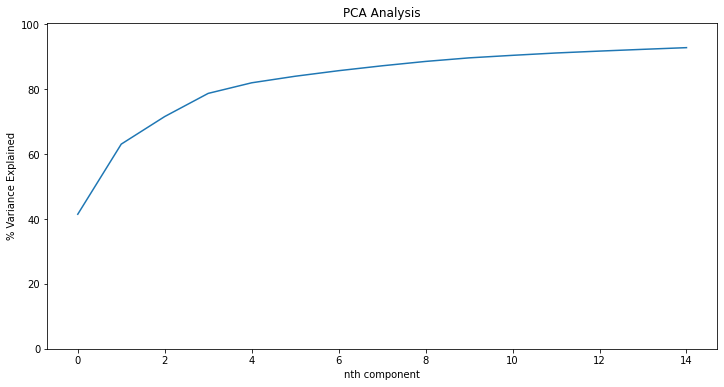

In [6]:
var=np.cumsum(pca.explained_variance_ratio_ *100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('nth component')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

Now pre-process for using in clustering algorithm

In [7]:
comps =pca.components_
X = preprocessing.StandardScaler().fit_transform(comps.T)

# Part B. Unsupervised Learning:  Clustering with OPTICS
 - Input dimension-reduced data from above
 - Orgainize and analyze clusters

For pairs trading we must have min_samples >= 2. A lower min_samples value creates more clusters, with (typically) fewer members, which could limit the number of co-integrating pairs per cluster. 

After experimenting I went with min_samples = 3. 

In [8]:
# get_clusters uses OPTICS to generate clusters
from helper_functions import get_clusters
clusters = get_clusters(data = X, tickers = list(returns), min_samples = 3)
num_clusters = len(clusters)
print('Total number of clusters:', num_clusters, '\n')

print('Tickers by cluster\n')
for i in range(num_clusters):
    print(i+1, clusters[i])

Total number of clusters: 14 

Tickers by cluster

1 ['DBS', 'SIVR', 'SLV', 'SLVO']
2 ['DBP', 'DGL', 'GLD', 'GLDI', 'GLTR', 'IAU', 'OUNZ', 'PPLT', 'SGOL', 'UBG']
3 ['DJCI', 'DJP', 'FTGC']
4 ['BCM', 'DBC', 'PDBC', 'RJI']
5 ['BNO', 'DBE', 'DBO', 'RJN', 'UGA', 'USL', 'USO']
6 ['CANE', 'DBA', 'FUD', 'RJA', 'SOYB']
7 ['CGW', 'FILL', 'FIW', 'NLR', 'PHO', 'PIO']
8 ['FENY', 'IYE', 'VDE', 'XLE']
9 ['PXE', 'PXI', 'RYE']
10 ['AMJ', 'AMLP', 'AMU', 'MLPA', 'MLPC', 'MLPG', 'MLPI', 'MLPY', 'ZMLP']
11 ['DGZ', 'DZZ', 'GLL']
12 ['IEZ', 'OIH', 'PSCE', 'PXJ', 'XES']
13 ['SIL', 'SILJ', 'SLVP']
14 ['GDX', 'RING', 'SGDM']


/home/christopher/anaconda3/envs/pairs/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass min_samples=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Part C: Pairs selection criteria
The Sarmento paper requires that all pairs are:
  - cointegrated
  - mean-reverting.  Specifically that the Hurst exponent is < 0.5
  - have a coherent mean-reversion time and trading period.  Specifically that the spread has a half-life of less than one year (and greater than 1 day).
  - spread cross the mean at least 12 times per year.

In [9]:
# Cointegration

# get_coint_pairs simply does a pairwise calculation of all potential pairs in each cluster and 'keeps' the cointegrated pairs
# and disregards those pairs that are not cointegrated.
# 5% significance value is used.

from helper_functions import get_coint_pairs
pairs = get_coint_pairs(clusters=clusters, pval_thresh=0.05, prices=prices)

c=0
coint_pairs = []
for i in range(num_clusters):
    l=len(pairs[i])
    if l > 0:
        print('cluster', i+1, 'has', l, 'cointigrated pairs')
        print(pairs[i],'\n')
        coint_pairs.append(pairs[i])
    c+=l
coint_pairs=coint_pairs[0]
print('Total number of conitegrated pairs', c)

cluster 2 has 11 cointigrated pairs
[('DBP', 'GLDI'), ('DGL', 'UBG'), ('GLD', 'OUNZ'), ('GLD', 'SGOL'), ('GLD', 'UBG'), ('GLDI', 'UBG'), ('GLTR', 'UBG'), ('IAU', 'UBG'), ('OUNZ', 'SGOL'), ('OUNZ', 'UBG'), ('SGOL', 'UBG')] 

cluster 5 has 2 cointigrated pairs
[('DBO', 'UGA'), ('UGA', 'USO')] 

cluster 6 has 1 cointigrated pairs
[('FUD', 'SOYB')] 

cluster 7 has 2 cointigrated pairs
[('FIW', 'NLR'), ('NLR', 'PHO')] 

cluster 10 has 6 cointigrated pairs
[('AMJ', 'AMU'), ('AMJ', 'MLPY'), ('AMLP', 'MLPY'), ('AMU', 'MLPY'), ('MLPC', 'MLPY'), ('MLPI', 'MLPY')] 

Total number of conitegrated pairs 22


Now derive the spread for the co-integrated pairs.

In [10]:
# derive coefficient and spread
from helper_functions import get_spread

spreads=[]
coeffs=[]
for pair in coint_pairs:
    coeff, spread = get_spread(pair, prices)
    spreads.append(spread)
    coeffs.append(coeff)

Spread of DBP and GLDI


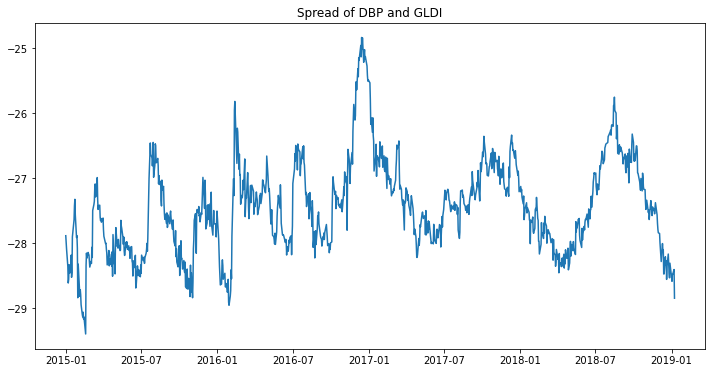

In [11]:
#Example of spread time series
spread=spreads[0]
p1, p2 =coint_pairs[0]
plt.figure(figsize=(12,6))
#plt.xlabel('time')
title_string ='Spread of ' +  p1 +' and '+ p2 
print(title_string)
plt.title(title_string)
plt.plot(spread)

This series is stationary and appears to be mean reverting.

Now test the spreads for their various properties: mean reversion (Hurst < 0.5), half-life <1 year, mean crossings > 12 per year

In [12]:
#spreads is list of spreads that are cointegrated
# the next few function calls reduce that list even more and capture only those that are mean reverting, half-life <1 year, cross at least 12 times per year
from helper_functions import get_mean_reverting, get_mean_crossing, get_half_life, half_life

print('Number of cointegrating pairs', len(coint_pairs))
print(coint_pairs)

mean_rev = get_mean_reverting(spreads, coint_pairs)
print('\nNumber of cointiegrating AND mean reverting pairs', len(mean_rev))
print(mean_rev)

mean_cross = get_mean_crossing(spreads, coint_pairs)
print('\nNumber of cointiegrating AND mean crossing pairs', len(mean_cross))
print(mean_cross)

half_life_list = get_half_life(spreads, coint_pairs)
print('\nNumber of cointiegrating AND "half-life" pairs', len(half_life_list))
print(half_life_list)

Number of cointegrating pairs 11
[('DBP', 'GLDI'), ('DGL', 'UBG'), ('GLD', 'OUNZ'), ('GLD', 'SGOL'), ('GLD', 'UBG'), ('GLDI', 'UBG'), ('GLTR', 'UBG'), ('IAU', 'UBG'), ('OUNZ', 'SGOL'), ('OUNZ', 'UBG'), ('SGOL', 'UBG')]

Number of cointiegrating AND mean reverting pairs 11
[('DBP', 'GLDI'), ('DGL', 'UBG'), ('GLD', 'OUNZ'), ('GLD', 'SGOL'), ('GLD', 'UBG'), ('GLDI', 'UBG'), ('GLTR', 'UBG'), ('IAU', 'UBG'), ('OUNZ', 'SGOL'), ('OUNZ', 'UBG'), ('SGOL', 'UBG')]

Number of cointiegrating AND mean crossing pairs 11
[('DBP', 'GLDI'), ('DGL', 'UBG'), ('GLD', 'OUNZ'), ('GLD', 'SGOL'), ('GLD', 'UBG'), ('GLDI', 'UBG'), ('GLTR', 'UBG'), ('IAU', 'UBG'), ('OUNZ', 'SGOL'), ('OUNZ', 'UBG'), ('SGOL', 'UBG')]

Number of cointiegrating AND "half-life" pairs 8
[('DBP', 'GLDI'), ('DGL', 'UBG'), ('GLD', 'UBG'), ('GLDI', 'UBG'), ('GLTR', 'UBG'), ('IAU', 'UBG'), ('OUNZ', 'UBG'), ('SGOL', 'UBG')]


In [13]:
# mean reversion (hurst criteria) does not reject any pairs and can be ignored - for this example only.
# final set of pairs mean-crossing pairs with half-life less than 1 year (250 days) and greater than 1 day
set1 = set(mean_cross)
final_list = list(set1.intersection(half_life_list))
print('Number of pairs that satisfy all criteria:', len(final_list))
print(final_list)

Number of pairs that satisfy all criteria: 8
[('GLD', 'UBG'), ('GLDI', 'UBG'), ('SGOL', 'UBG'), ('GLTR', 'UBG'), ('IAU', 'UBG'), ('DBP', 'GLDI'), ('OUNZ', 'UBG'), ('DGL', 'UBG')]


# Extension: Backtesting out-of-sample

In this section section I implement a simple 2SD Bollinger band trading rule over validation period (2019-2020) on co-integrated pairs indenfied in formation period (2015-2018). Cointegration coefficient is estimated over formation period also.

I then analyze the impace of each 'additional' pair trading criterion and finally all citeria in combination.

In [14]:
from helper_functions import back_test_all
results_all = back_test_all(coint_pairs, coeffs, prices_test) #note prices_test is out-o-sample prices NOT used in cluster and coefficient estimation
#results_all.tail()

In [15]:
#get results for each criteria: mean cross, half-life and both of these
diff=list(set(list(results_all)).difference(set(mean_cross)))
results_mean_crossing = results_all.drop(columns = diff)

diff=list(set(list(results_all)).difference(set(half_life_list)))
results_half_life = results_all.drop(columns = diff)

diff=list(set(list(results_all)).difference(set(final_list)))
results_final = results_all.drop(columns = diff)

<AxesSubplot:xlabel='Date'>

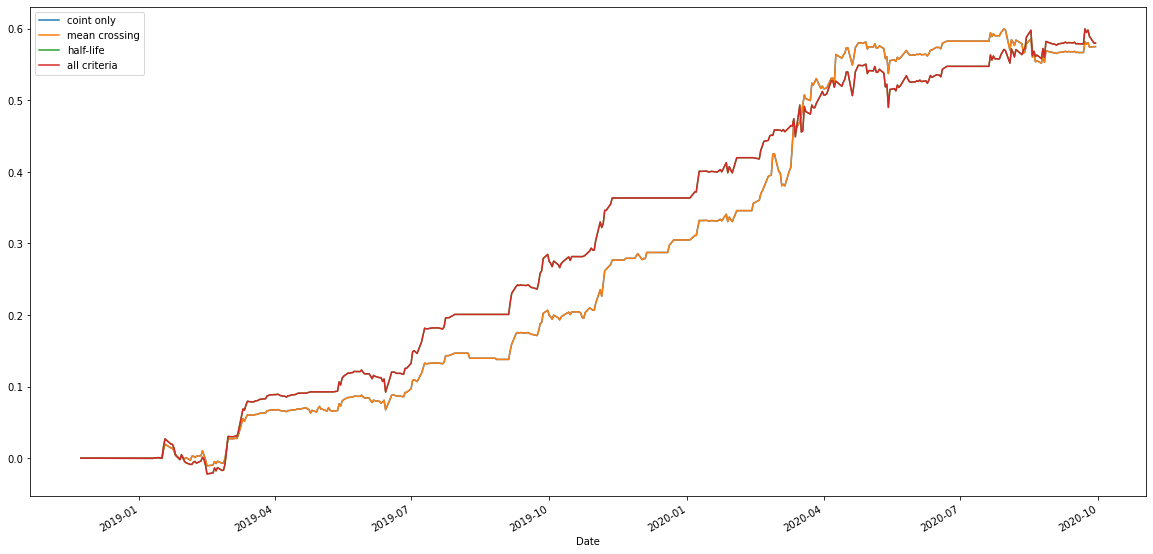

In [16]:
summary=pd.DataFrame()
summary['coint only'] = results_all.mean(axis=1)
summary['mean crossing'] = results_mean_crossing.mean(axis=1)
summary['half-life']= results_half_life.mean(axis=1)
summary['all criteria'] = results_final.mean(axis=1)
summary.to_csv('./backtests/summary.csv')

summary.plot(figsize=(20,10))
#summary.plot.line()
